In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb

This is an attempt at recreating a predictive policing model as roughly outlined [here](https://www.predpol.com/how-predictive-policing-works/) by PredPol, a company that provides crime prediction tools that are being used by police departments in major cities throughout the country.  I will not use the algorithm that they [proudly display](https://www.predpol.com/technology/) on their site but I will use only "objective" data that they also tout: time, location, and type.  All crime data is obtained [here](https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-2019/63jg-8b9z).

## Data Cleaning and Prep

In [2]:
crime = pd.read_csv("Crime_Data_from_2016_to_2019.csv")

crime['crime_cat'] = crime['Crm Cd'] // 100 
crime['time'] = crime['TIME OCC'] // 100

# filter out any lat or lon that are definitely out of range
crime = crime[(crime['LON'] != 0) & (crime['LAT'] != 0)]

#set to datetime 
crime['DATE OCC'] = pd.to_datetime(crime['DATE OCC'])
# filter to dates 2016 and on
crime = crime[crime['DATE OCC'] >= '2016-01-01']

# make sure our dates are in our desired order
crime = crime.sort_values('DATE OCC')

I want to get into a few things about how I'll be working with the data before I jump into any modeling portion.

There are 141 unique crime codes and treating the whole as a categorical feature would be dangerous for predicting the low frequency crimes that are still high severity (i.e. murder, rape, kidnapping).  However our crime codes categorize crime types for each 100 block.  They do not occur at equal frequencies and the severity can range within the block.  I'll insert a table of the crime descriptions to their categories for reference.  

For time of day I will break times into three factors: Late night/morning (3:00-10:59 AM), Midday (11-5:59 PM), and Night (6-2:59 AM).  These aren't meant to be particularly even periods of time, just rough estimates so we aren't using a factor variable with 24 different categories.

We will merge some of our lat lon coordinates into general zones for when we have to group data together. 10 lon groupings, 10 lat groupings.   

In [3]:
# we want to group locations in a grid of 100 spaces
# also want to store counts in each of these locations for visualization purposes 

crime_counts = np.zeros((10, 10))
lat_range = np.arange(np.min(crime['LAT']), np.max(crime['LAT']) + 0.0025, -(np.min(crime['LAT']) - np.max(crime['LAT']) + 0.0025) / 11 )
lon_range = np.arange(np.min(crime['LON']), np.max(crime['LON']) + 0.00219, abs(np.min(crime['LON']) - np.max(crime['LON']) + 0.00219 ) / 11)
crime['lat_area'] = np.nan 
crime['lon_area'] = np.nan
for i in range(len(crime)):
    for a in range(10):
        if lon_range[a] <= (crime['LON'].values[i]) < lon_range[a + 1]:
            lon_box = a
            crime['lon_area'].values[i] = lon_box
            break
    for b in range(10):
        if lat_range[b] <= (crime['LAT'].values[i]) < lat_range[b + 1]:
            lat_box = b
            crime_counts[lat_box , lon_box] += 1
            crime['lat_area'].values[i] = lat_box
            break 
            
    

Now we'll add our time of day 3 level factor variable and calculate the running 90 day crime count as well.  This count is grouped by the lat lon area, time of day, and crime category.  As such we will not use the first 90 days in the set as it'd contain incomplete data.  

In [4]:
# set up categorical data 
crime['tod'] = np.nan
for i in range(len(crime)):
    if 3 <= crime['time'].values[i] <= 10:
        crime['tod'].values[i] = 0
    elif 11 <= crime['time'].values[i] <= 16:
        crime['tod'].values[i] = 1
    else:
        crime['tod'].values[i] = 2
        


Unfortunately due to the size of our dataframe and the amount of time it will take to iterate through the data for this specific column, we will shrink the totality of our train and test sets to 100,000 rows.  I am not sure of a more computationally efficient way to calculate this off the top of my head but with the computing power I have and the fact that I'll still have hopefully more than enough data, it's a choice I'm okay with making at this point.  

In [5]:
# group on date, crime_cat, time of day, lat lon
# hold a separate dataset with only the variables we care for right now
smaller = crime[len(crime) - 100000:len(crime)]

group = smaller[['DATE OCC',  'lat_area', 'lon_area', 'tod']]

grouped = group.groupby(['DATE OCC',  'lat_area', 'lon_area', 'tod']).size().reset_index(name = 'counts')

grouped['window_count'] = 0

# generate 30 day counts 
start_date = datetime.datetime(2016, 1, 1) + datetime.timedelta(30)

for i in range(len(grouped)):
    # filter for rows before summing
    grouped['window_count'].values[i] = np.nan_to_num(np.mean(grouped[(grouped['lat_area'] == grouped['lat_area'].values[i]) & 
                   (grouped['lon_area'] == grouped['lon_area'].values[i]) & 
                   (grouped['tod'] == grouped['tod'].values[i]) &
                   (grouped['DATE OCC'] < grouped['DATE OCC'].values[i]) &
                   (grouped['DATE OCC'] >= (grouped['DATE OCC'].values[i] - np.timedelta64(30, 'D')))]['counts']))
    
    
# grab rows that are greater than 30 days beyond 1-1-2016
grouped = grouped[grouped['DATE OCC'] >= start_date]

Before we begin modeling, we have to convert our factor variables into one hot encoded columns.  I don't anticipate any problems with converting our time of day factor but there may be a sparsity issue with some of the more rare crime categories.  I will not be treating the geographical areas as any type of factors as our decision tree based model will be able to partition the two variables in a 2d space.

In [6]:
# one hot encode factor vars (tod, crime_cat)
grouped = pd.get_dummies(grouped.astype(str), prefix = [ 'tod'], columns = [ 'tod'])


In [7]:
grouped = grouped.drop(columns = 'DATE OCC').astype('float64')

With our final data now prepped, we need to split into train and test groups.  For the purposes of this exercise our test set will be made up of the most recent data, our training set the older data. I'll use an 80-20 split.

In [8]:
# train test split 
train_len = np.round(len(grouped) * 0.8 )

train = grouped.iloc[0:int(train_len)]
test = grouped.iloc[int(train_len):len(grouped)]

## Modeling

Now we have our data set and can begin training

In [9]:
dtrain = xgb.DMatrix(train.drop(columns = 'counts'), label = train['counts'])
dtest = xgb.DMatrix(test.drop(columns = 'counts'), label = test['counts'])

# set parameters
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'reg:linear' , 
        'silent': 1}
param['eval_metric'] = 'rmse'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10)

[23:22:48] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:4.62215	train-rmse:4.75171
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:3.61334	train-rmse:3.73597
[2]	eval-rmse:2.99872	train-rmse:3.11669
[3]	eval-rmse:2.65176	train-rmse:2.76007
[4]	eval-rmse:2.46753	train-rmse:2.56376
[5]	eval-rmse:2.37522	train-rmse:2.46013
[6]	eval-rmse:2.32906	train-rmse:2.40517
[7]	eval-rmse:2.30948	train-rmse:2.37720
[8]	eval-rmse:2.30042	

In [10]:
# generate our predictions
preds = bst.predict(dtest)

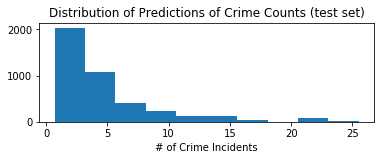

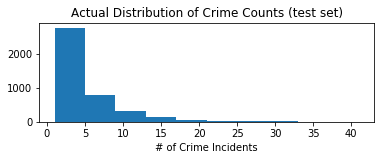

In [11]:
plt.subplot(2, 1, 1)
plt.hist(preds)
plt.xlabel('# of Crime Incidents')
plt.title('Distribution of Predictions of Crime Counts (test set)')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(test['counts'])
plt.xlabel('# of Crime Incidents')
plt.title('Actual Distribution of Crime Counts (test set)')
plt.show()

In [12]:
from sklearn.metrics import r2_score
r2_score(test['counts'], preds)

0.7613763078535917

In [13]:
# reappend preds count to test
test['predicted'] = preds

/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# randomly +- from window_count for pseudo prediction
test['random_pred'] = test['window_count'] + np.random.choice([-1, 1], size = len(test))

/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
test.head()

,lat_area,lon_area,counts,window_count,tod_0.0,tod_1.0,tod_2.0,predicted,random_pred
16543,5.0,4.0,6.0,3.0,0.0,1.0,0.0,3.921645,2.0
16544,5.0,4.0,7.0,6.0,0.0,0.0,1.0,6.043744,7.0
16545,5.0,5.0,3.0,2.0,1.0,0.0,0.0,2.623921,1.0
16546,5.0,5.0,4.0,3.0,0.0,1.0,0.0,3.561833,4.0
16547,5.0,5.0,3.0,4.0,0.0,0.0,1.0,4.909706,5.0


In [16]:
r2_score(test['counts'], test['random_pred'])

0.7031619809449291

In [17]:
two = test[test['tod_2.0'] == 1]
one = test[test['tod_1.0'] == 1]
zero = test[test['tod_0.0'] == 1]

group_two = two.groupby(by = ['lat_area', 'lon_area']).mean().reset_index()
group_one = one.groupby(by = ['lat_area', 'lon_area']).mean().reset_index()
group_zero = zero.groupby(by = ['lat_area', 'lon_area']).mean().reset_index()

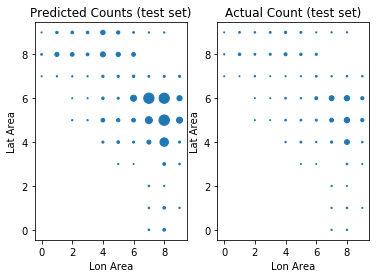

In [40]:
plt.subplot(1, 2, 1)
plt.scatter(group_two['lon_area'], group_zero['lat_area'], s = (group_two['predicted']) ** 1.5)
plt.xlabel('Lon Area')
plt.ylabel('Lat Area')
plt.title('Predicted Counts (test set)')

plt.subplot(1, 2, 2)
plt.scatter(group_two['lon_area'], group_two['lat_area'], s = (group_zero['counts']) ** 1.5)
plt.xlabel('Lon Area')
plt.ylabel('Lat Area')
plt.title('Actual Count (test set)')
plt.show()